<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Stock%20Price%20Prediction%20BiLSTM%20-%20AAPL/aapl_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [69]:
!pip install -q yfinance
!pip install -q ta

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from ta import add_all_ta_features
from ta.utils import dropna

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Get Data

In [71]:
def download_data(symbol="AAPL", start_date="2015-01-01", end_date="2025-07-30", interval="1d"):
    data = yf.download(symbol, start=start_date,
                       end=end_date, interval=interval)
    return data

# Get data
df = download_data()

/tmp/ipython-input-2534171954.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date,
[*********************100%***********************]  1 of 1 completed


In [72]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288584,24.757338,23.848709,24.746230,212818400
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000
2015-01-06,23.606554,23.866479,23.244435,23.668758,263188400
2015-01-07,23.937569,24.037539,23.704302,23.815381,160423600
2015-01-08,24.857309,24.915071,24.148623,24.266369,237458000


# Process Data

In [73]:
def process_data(df):
    """Clean and prepare the data."""
    df = df.dropna()
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.index = pd.to_datetime(df.index)
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume'] # Corrected column renaming
    return df

# Apply func to dataframe
df = process_data(df)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2015-01-02 to 2025-07-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2658 non-null   float64
 1   High    2658 non-null   float64
 2   Low     2658 non-null   float64
 3   Close   2658 non-null   float64
 4   Volume  2658 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 124.6 KB


# Handle Outliers

In [75]:
def handle_outliers(df, column="Close"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply func
df = handle_outliers(df)

# Feature Engineering

In [76]:
def engineer_features(df):
    """
    Manually add technical indicators and temporal features using pandas and numpy.
    """
    # Temporal features (use df.index for datetime features since Date is the index)
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear

    # Lag features
    for lag in [1, 3, 5, 10]:
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

    # Rolling statistics (Moving Averages and Std)
    for window in [5, 10, 20]:
        df[f'Close_Rolling_Mean_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'Close_Rolling_Std_{window}'] = df['Close'].rolling(window=window).std()

    # Exponential Moving Average (EMA)
    for span in [12, 26]:
        df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()

    # MACD (Manual calculation)
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # RSI (Manual calculation)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)

    # Drop NaN after feature creation
    df.dropna(inplace=True)

    return df

df = engineer_features(df)

In [77]:
df.head()

,Open,High,Low,Close,Volume,DayOfWeek,Month,Quarter,Year,DayOfYear,...,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,BB_Middle,BB_Std,BB_Upper,BB_Lower
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-30,26.303556,26.659009,25.959210,26.028080,334982000,4,1,1,2015,30,...,25.096623,24.716536,0.380087,0.174825,0.205263,58.434325,24.579942,0.798225,26.176391,22.983492
2015-02-02,26.225800,26.474616,25.788148,26.354650,250956400,0,2,1,2015,33,...,25.290166,24.837878,0.452288,0.230317,0.221971,66.039607,24.683245,0.887259,26.457764,22.908726
2015-02-03,26.325774,26.456847,26.128053,26.359098,207662800,1,2,1,2015,34,...,25.454617,24.950561,0.504056,0.285065,0.218991,64.899206,24.820983,0.924017,26.669018,22.972949
2015-02-04,26.325769,26.772308,26.283558,26.561256,280598800,2,2,1,2015,35,...,25.624869,25.069871,0.554998,0.339052,0.215946,66.956182,24.968718,0.955305,26.879329,23.058108
2015-02-05,26.768685,26.815523,26.596948,26.750843,168984800,3,2,1,2015,36,...,25.798096,25.194388,0.603708,0.391983,0.211725,75.500241,25.109382,1.001486,27.112355,23.106409


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2639 entries, 2015-01-30 to 2025-07-29
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   2639 non-null   float64
 1   High                   2639 non-null   float64
 2   Low                    2639 non-null   float64
 3   Close                  2639 non-null   float64
 4   Volume                 2639 non-null   int64  
 5   DayOfWeek              2639 non-null   int32  
 6   Month                  2639 non-null   int32  
 7   Quarter                2639 non-null   int32  
 8   Year                   2639 non-null   int32  
 9   DayOfYear              2639 non-null   int32  
 10  Close_Lag_1            2639 non-null   float64
 11  Close_Lag_3            2639 non-null   float64
 12  Close_Lag_5            2639 non-null   float64
 13  Close_Lag_10           2639 non-null   float64
 14  Close_Rolling_Mean_5   2639 non-null  

# Feature Selection

In [79]:
def select_features(df, target_col='Close', threshold=0.2):
    """Select features based on correlation with target."""
    corr_matrix = df.corr()
    target_corr = corr_matrix[target_col].abs()
    selected_features = target_corr[target_corr > threshold].index.tolist()
    selected_features.remove(target_col)  # Remove target from features
    print(f"\nSelected features (correlation > {threshold}): {selected_features}")
    return df[selected_features + [target_col]]

# Apply func
df = select_features(df)
df.info()


Selected features (correlation > 0.2): ['Open', 'High', 'Low', 'Volume', 'Year', 'Close_Lag_1', 'Close_Lag_3', 'Close_Lag_5', 'Close_Lag_10', 'Close_Rolling_Mean_5', 'Close_Rolling_Std_5', 'Close_Rolling_Mean_10', 'Close_Rolling_Std_10', 'Close_Rolling_Mean_20', 'Close_Rolling_Std_20', 'EMA_12', 'EMA_26', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2639 entries, 2015-01-30 to 2025-07-29
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   2639 non-null   float64
 1   High                   2639 non-null   float64
 2   Low                    2639 non-null   float64
 3   Volume                 2639 non-null   int64  
 4   Year                   2639 non-null   int32  
 5   Close_Lag_1            2639 non-null   float64
 6   Close_Lag_3            2639 non-null   float64
 7   Close_Lag_5            2639 non-null   float64


# Prepare Data

In [80]:
def prepare_data(df, target_col="Close", time_steps=30):
    """Scale data and create sequences for LSTM."""
    features = df.drop([target_col], axis=1)
    target = df[target_col]

    # Scale features and target
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    features_scaled = feature_scaler.fit_transform(features)
    target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

    # Create Sequences
    X, y = [], []
    for i in range(time_steps, len(features_scaled)):
        X.append(features_scaled[i-time_steps:i])
        y.append(target_scaled[i])

    X, y = np.array(X), np.array(y)

    return X, y, feature_scaler, target_scaler, features.columns

# Apply func
X, y, feature_scaler, target_scaler, feature_columns = prepare_data(df, time_steps=30)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (2175, 30, 21)
Shape of y_train: (2175,)
Shape of X_test: (434, 30, 21)
Shape of y_test: (434,)


# Build Model


Fold 1
X_train shape: (439, 30, 21), y_train shape: (439,)
X_test shape: (434, 30, 21), y_test shape: (434,)
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - loss: 0.0011 - val_loss: 1.5457e-05
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 7.6820e-05 - val_loss: 7.8368e-05
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 4.3125e-05 - val_loss: 4.8989e-05
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - loss: 2.8226e-05 - val_loss: 5.5189e-05
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 2.4503e-05 - val_loss: 2.4698e-05
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 2.2791e-05 - val_loss: 6.1163e-05
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 2.2625e-05 - val_loss: 4.5408e-05
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 2.3075e-05 - val_loss: 1.8230e-05
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 2.0098e-05 - val_loss: 2.6943e-05
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━

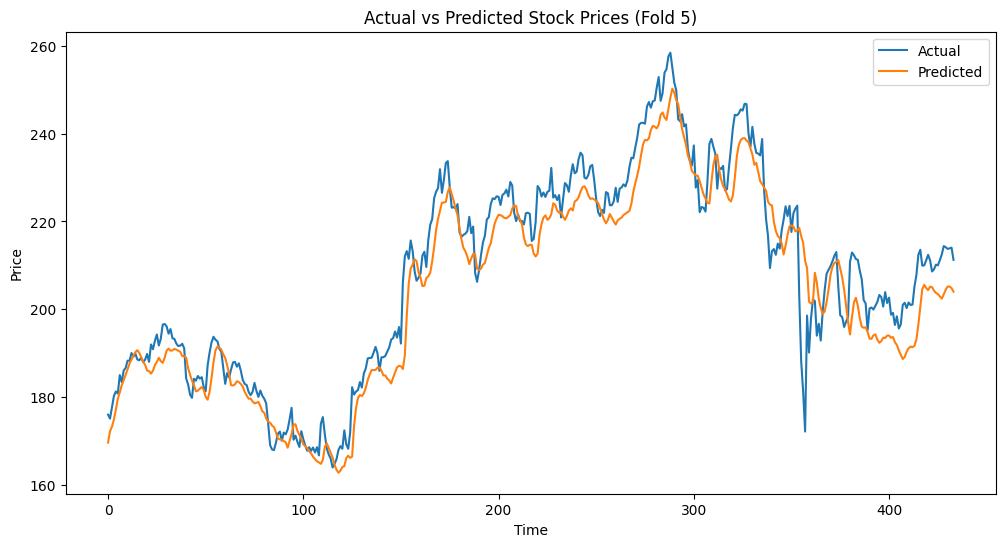

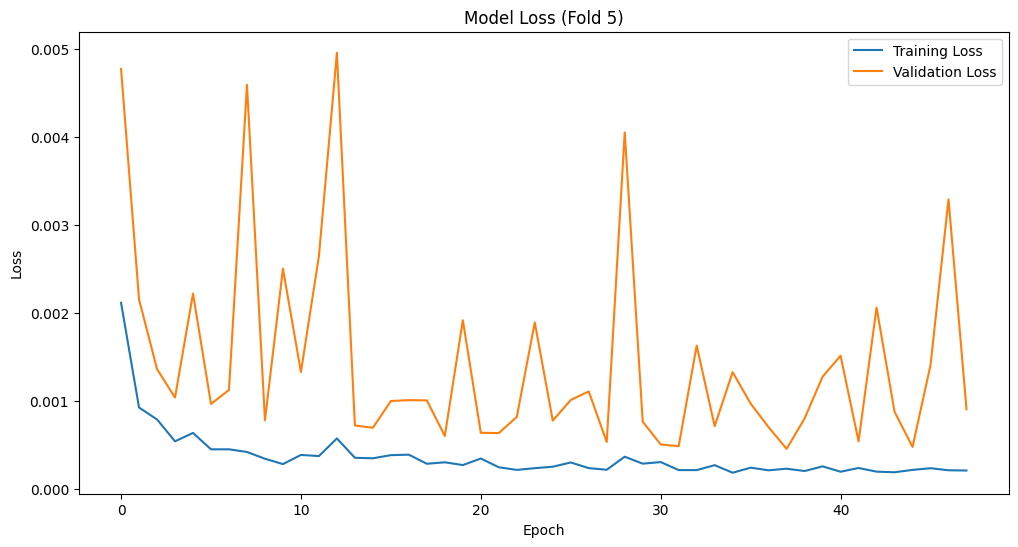

In [81]:
# Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Build Model
    def build_model(input_shape):
        """Build LSTM model with Functional API."""
        inputs = Input(shape=input_shape)
        x = Bidirectional(LSTM(150, return_sequences=True))(inputs)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(150, return_sequences=False))(x)
        x = Dropout(0.3)(x)
        x = Dense(50, activation="relu")(x)
        outputs = Dense(1)(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
        return model

    model = build_model((X_train.shape[1], X_train.shape[2]))

    # Train
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(f"best_model_fold_{fold + 1}.keras", monitor="val_loss", save_best_only=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=16,
        epochs=100,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Evaluate
    y_pred = model.predict(X_test)
    y_pred = y_pred.squeeze()  # Ensure 1D
    y_test = y_test.squeeze()

    # Inverse transform predictions and actual values
    y_pred_unscaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"Fold {fold + 1} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plot Actual vs Predicted for the last fold
    if fold == 4:
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_unscaled, label='Actual')
        plt.plot(y_pred_unscaled, label='Predicted')
        plt.title(f'Actual vs Predicted Stock Prices (Fold {fold + 1})')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss (Fold {fold + 1})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Train the Model

In [82]:
# Train final model on all data
model = build_model((X.shape[1], X.shape[2]))
history = model.fit(
    X, y,
    validation_split=0.2,
    batch_size=16,
    epochs=100,
    callbacks=[early_stopping, ModelCheckpoint("best_model_final.keras", monitor="val_loss", save_best_only=True)],
    verbose=1)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 8.5208e-04 - val_loss: 0.0092
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - loss: 9.9165e-04 - val_loss: 0.0028
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - loss: 8.0453e-04 - val_loss: 0.0035
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 218ms/step - loss: 7.2915e-04 - val_loss: 0.0121
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - loss: 6.7390e-04 - val_loss: 0.0075
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 5.9365e-04 - val_loss: 0.0072
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - loss: 4.4724e-04 - val_loss: 0.0057
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - loss: 5.9848e-04 - val_loss: 0.0015
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 5.

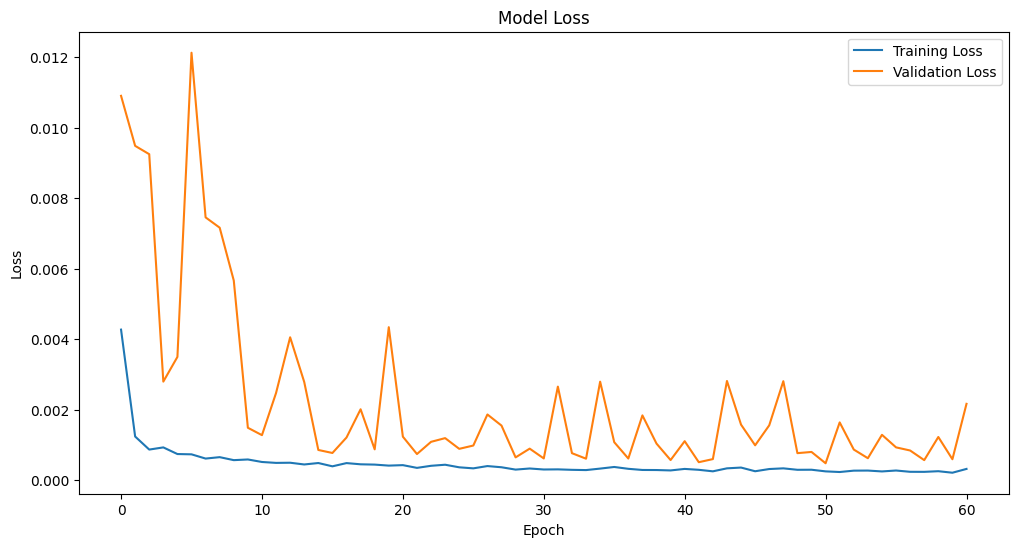

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model

In [84]:
# Prediction Function
def predict_future(model, last_sequence, feature_scaler, target_scaler, feature_columns, steps=5):
    """Predict future stock prices for a given number of steps."""
    current_sequence = last_sequence.copy()
    predictions = []

    for _ in range(steps):
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        pred = model.predict(current_sequence_reshaped, verbose=0)[0][0]
        pred_unscaled = target_scaler.inverse_transform([[pred]])[0][0]
        predictions.append(pred_unscaled)

        new_row = current_sequence[-1].copy()
        close_idx = list(feature_columns).index('Close_Lag_1')
        new_row[close_idx] = pred
        current_sequence = np.vstack((current_sequence[1:], new_row))

    return predictions

# Prepare last sequence for future prediction
last_sequence = feature_scaler.transform(df.drop(['Close'], axis=1).iloc[-30:])
future_predictions = predict_future(model, last_sequence, feature_scaler, target_scaler, feature_columns, steps=5)
print("\nFuture 5-day predictions:", future_predictions)


Future 5-day predictions: [np.float64(213.95072063377162), np.float64(213.6054877682195), np.float64(213.38749592966812), np.float64(213.31822828962137), np.float64(213.4315109235276)]
